In [2]:
import pandas as pd
import re
import string

# Load the dataset
file_path = r"D:\Download\data_news.xlsx"
df = pd.read_excel(file_path)

# Show dataset info and missing values
print("Dataset Shape:", df.shape)
print("\nMissing Values:\n", df.isnull().sum())
print("\nSample Data:\n", df.head())

# Fill missing short descriptions and combine with headlines
df['short_description'] = df['short_description'].fillna('')  # ✅ fixed to avoid FutureWarning
df['text'] = df['headline'] + ' ' + df['short_description']

# Drop unnecessary columns and rows with missing text or category
df = df[['category', 'text']]
df.dropna(subset=['text', 'category'], inplace=True)

# Preprocessing function to clean text
def preprocess(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)  # remove URLs
    text = re.sub(r'\d+', '', text)  # remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # remove punctuation
    text = re.sub(r'\s+', ' ', text).strip()  # normalize whitespace
    return text

# Apply the preprocessing function
df['clean_text'] = df['text'].apply(preprocess)

# Display final cleaned data and category distribution
print("\nCleaned Data Sample:\n", df[['category', 'clean_text']].head())
print("\nCategory Distribution:\n", df['category'].value_counts())


Dataset Shape: (50000, 5)

Missing Values:
 category                0
headline                0
links                   0
short_description       6
keywords             2706
dtype: int64

Sample Data:
    category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resti

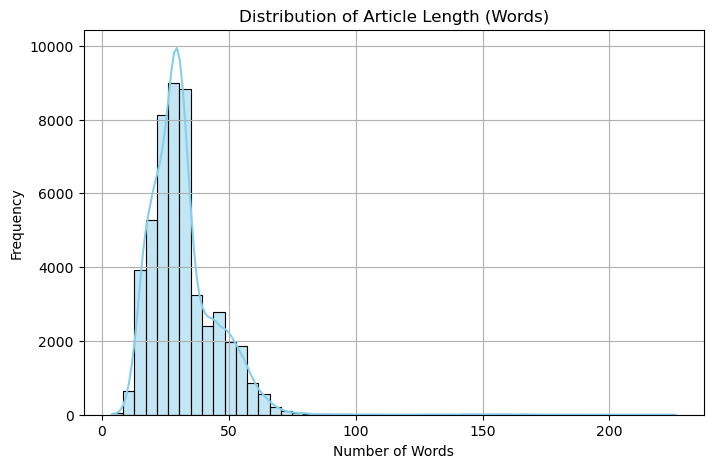

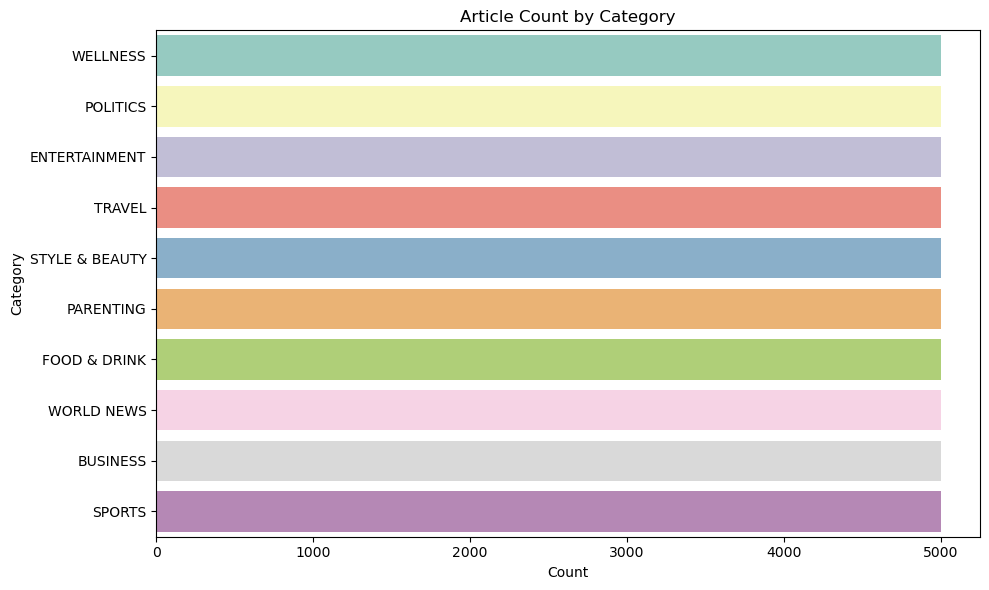


TF-IDF matrix shape: (50000, 5000)
Sample feature names: ['aaron' 'abandoned' 'ability' 'able' 'aboard' 'abortion' 'abroad'
 'absence' 'absolute' 'absolutely']


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer

# 1. EDA - Article Text Length Distribution
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

plt.figure(figsize=(8,5))
sns.histplot(df['text_length'], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Article Length (Words)")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# 2. EDA - Category Distribution
plt.figure(figsize=(10,6))
sns.countplot(data=df, y='category', hue='category', order=df['category'].value_counts().index, palette='Set3', legend=False)
plt.title("Article Count by Category")
plt.xlabel("Count")
plt.ylabel("Category")
plt.tight_layout()
plt.show()

# 3. TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')

# Transform text to TF-IDF features
X = tfidf.fit_transform(df['clean_text'])

# Extract labels
y = df['category']

# Show output
print(f"\nTF-IDF matrix shape: {X.shape}")
print("Sample feature names:", tfidf.get_feature_names_out()[:10])


In [5]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# 1. Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Model training and evaluation function
def train_evaluate_model(model, model_name):
    print(f"\n===== {model_name} =====")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

    # Cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')
    print(f"\nCross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# 3. Initialize models
lr_model = LogisticRegression(max_iter=1000)
nb_model = MultinomialNB()
svm_model = LinearSVC()

# 4. Train and evaluate each model
train_evaluate_model(lr_model, "Logistic Regression")
train_evaluate_model(nb_model, "Naive Bayes")
train_evaluate_model(svm_model, "Support Vector Machine (SVM)")



===== Logistic Regression =====
Accuracy: 0.7905

Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.74      0.76      0.75      1000
 ENTERTAINMENT       0.76      0.78      0.77      1000
  FOOD & DRINK       0.83      0.86      0.85      1000
     PARENTING       0.77      0.76      0.77      1000
      POLITICS       0.76      0.74      0.75      1000
        SPORTS       0.88      0.88      0.88      1000
STYLE & BEAUTY       0.86      0.83      0.85      1000
        TRAVEL       0.80      0.77      0.79      1000
      WELLNESS       0.71      0.75      0.73      1000
    WORLD NEWS       0.80      0.77      0.78      1000

      accuracy                           0.79     10000
     macro avg       0.79      0.79      0.79     10000
  weighted avg       0.79      0.79      0.79     10000

Confusion Matrix:
 [[761  19  17  28  54   9  12  17  55  28]
 [ 14 776  15  40  30  33  35  20  27  10]
 [ 13  16 862  16   5   5  20  31


===== Logistic Regression Evaluation =====
Accuracy: 0.7905

Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.74      0.76      0.75      1000
 ENTERTAINMENT       0.76      0.78      0.77      1000
  FOOD & DRINK       0.83      0.86      0.85      1000
     PARENTING       0.77      0.76      0.77      1000
      POLITICS       0.76      0.74      0.75      1000
        SPORTS       0.88      0.88      0.88      1000
STYLE & BEAUTY       0.86      0.83      0.85      1000
        TRAVEL       0.80      0.77      0.79      1000
      WELLNESS       0.71      0.75      0.73      1000
    WORLD NEWS       0.80      0.77      0.78      1000

      accuracy                           0.79     10000
     macro avg       0.79      0.79      0.79     10000
  weighted avg       0.79      0.79      0.79     10000



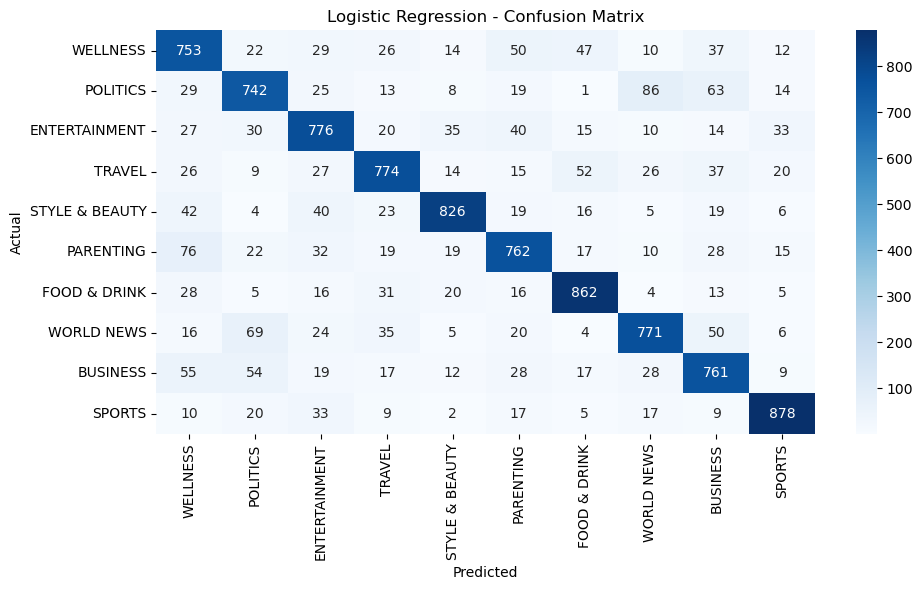


===== Naive Bayes Evaluation =====
Accuracy: 0.7775

Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.74      0.71      0.73      1000
 ENTERTAINMENT       0.77      0.76      0.76      1000
  FOOD & DRINK       0.79      0.87      0.83      1000
     PARENTING       0.70      0.76      0.73      1000
      POLITICS       0.78      0.73      0.75      1000
        SPORTS       0.87      0.84      0.86      1000
STYLE & BEAUTY       0.85      0.82      0.84      1000
        TRAVEL       0.77      0.78      0.77      1000
      WELLNESS       0.72      0.73      0.73      1000
    WORLD NEWS       0.79      0.78      0.78      1000

      accuracy                           0.78     10000
     macro avg       0.78      0.78      0.78     10000
  weighted avg       0.78      0.78      0.78     10000



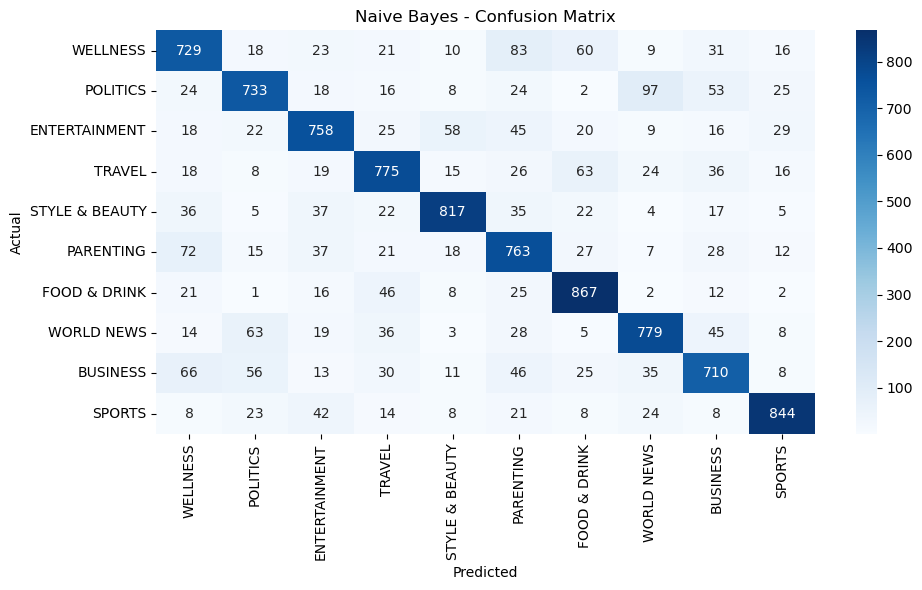


===== Support Vector Machine (SVM) Evaluation =====
Accuracy: 0.7866

Classification Report:
                precision    recall  f1-score   support

      BUSINESS       0.75      0.79      0.77      1000
 ENTERTAINMENT       0.77      0.75      0.76      1000
  FOOD & DRINK       0.82      0.85      0.83      1000
     PARENTING       0.76      0.77      0.76      1000
      POLITICS       0.76      0.73      0.75      1000
        SPORTS       0.87      0.91      0.89      1000
STYLE & BEAUTY       0.84      0.83      0.84      1000
        TRAVEL       0.78      0.78      0.78      1000
      WELLNESS       0.72      0.72      0.72      1000
    WORLD NEWS       0.79      0.75      0.77      1000

      accuracy                           0.79     10000
     macro avg       0.79      0.79      0.79     10000
  weighted avg       0.79      0.79      0.79     10000



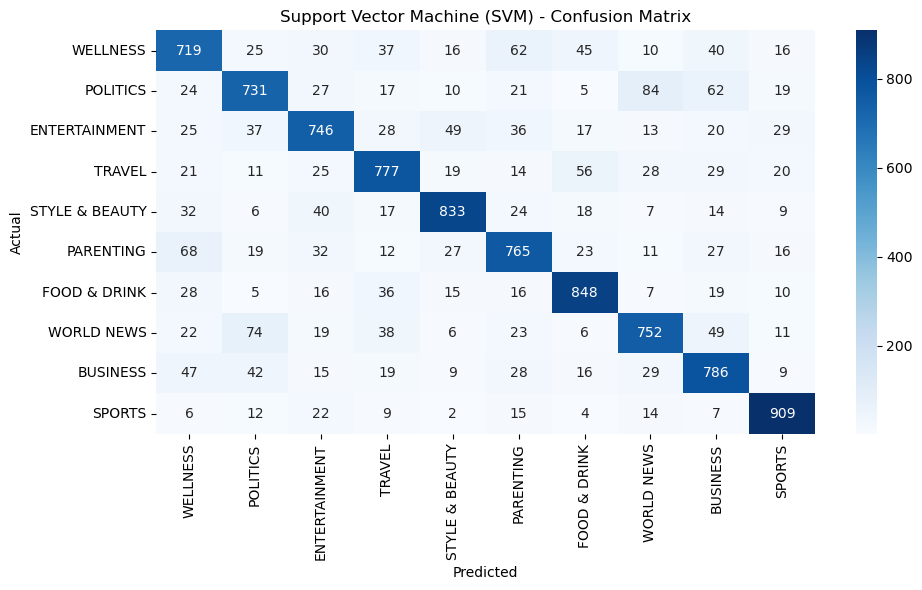

In [6]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Function to evaluate and visualize performance
def evaluate_model(model, model_name):
    print(f"\n===== {model_name} Evaluation =====")
    y_pred = model.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=df['category'].unique())

    plt.figure(figsize=(10, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=df['category'].unique(),
                yticklabels=df['category'].unique(), cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Evaluate all trained models
evaluate_model(lr_model, "Logistic Regression")
evaluate_model(nb_model, "Naive Bayes")
evaluate_model(svm_model, "Support Vector Machine (SVM)")
